# The HFM library - A fast marching solver with adaptive stencils 

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Sensitivity in semi-Lagrangian schemes

<!---The HFM library provides a variety of metric classes : isotropic, Riemannian, Rander, asymmetric quadratic, defined by a Hooke tensor, and more.--->

This notebook illustrates automatic differentiation with anisotropic metrics, and requires specific computational techniques in comparison to the isotropic case. We illustrate here their foundations and usage.
For that purpose, we are dependent on an implementation detail - semi-Lagrangian implementation - that is usually transparent to the user. 

The methods presented in this notebook apply to the following HFM models : `Rander2`, `AsymmetricQuadratic2`, `Seismic_`, `SeismicTopographic_` as well as `Isotropic_`, `Diagonal_`.
The underscore stands for $2$ or $3$. For two-dimensional Riemannian metrics, use `Rander2`.

**Eulerian vs Semi-Lagrangian schemes.**
The HFM (Hamiltonian Fast Marching) library takes its name from a family of Eulerian schemes based on a specific representation of the Hamiltonian, which are particularly efficient for Riemannian metrics and curvature penalized metrics, see:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

However, other classes of metrics (such as Rander, asymmetric quadratic, or hooke tensor defined), require a different approach. In their case, we rely on an adaptive semi-Lagrangian scheme, in the spirit of 
* Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557. [link](https://hal.archives-ouvertes.fr/hal-00736431)

**Semi-Lagrangian schemes** are discretizations of the eikonal equation 
$$
    F_x^*(\nabla u(x)) = 1
$$
in the following form which is closely related with Bellman's optimality principle
$$
    u(x) = \min_{y \in S(x)} F_x(x-y) + I_{S(x)} u(y),
$$
where $S(x)$ the *stencil* is a polygonal neighborhood of $x$ whose vertices are grid-points, and $I_S$ denotes piecewise linear interpolation.
The equality is imposed at all points of the discrete or continuous domain. In addition, adequate boundary conditions are imposed on the domain boundary, usually of Dirichlet and of outflow type.

**The geodesic flow.**
The minimizer $y_*(x) \in S(x)$ in the semi-lagrangian discretization of the eikonal equation has a geometrical interpretation: $v_*(x) = x-y_*(x)$ approximates the direction of the minimal geodesic passing through $x$, referred to as the geodesic flow direction. This data it is optionally exported by the HFM library, after normalization, under the name `geodesicFlow`.

<!---
Said otherwise, one has $V(x) \approx v_*$, where 
$$
    \gamma'(t) = V(\gamma(t)) \quad V(x) = \nabla F_x^*(\nabla u(x))
$$
--->

**The envelope theorem.**
Under suitable assumptions, one can differentiate the value of an optimization problem w.r.t. parameters, using the so-called envelope theorem: the extremizer variation can be ignored at first order.

Said otherwise, if the metric depends on a small parameter $\epsilon$, then
$$
    u(x;\epsilon) = F_x(v_*(x);\epsilon) + I_{S(x)}u(y_*(x);\epsilon) + o(\epsilon).
$$

As a result, if two parameter dependent metrics $F$ and $G$ obey
$$
    F_x(v_*(x); \epsilon) = G_x(v_*(x); \epsilon) + o(\epsilon),
$$
at all discretization points $x$, then they produce identical first order perturbations of $u$.
The HFM library takes advantage of this fact to simplify computations, but for that purposes needs the geodesic flow direction $v_*(x)$ to be computed in a preliminary step.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Forward differentiation](#1.-Forward-differentiation)
    * [1.1 Isotropic example](#1.1-Isotropic-example)
    * [1.2 Rander example](#1.2-Rander-example)
    * [1.3 Seismic example](#1.3-Seismic-example)
  * [2. Reverse differentiation](#2.-Reverse-differentiation)
    * [2.1 Isotropic example](#2.1-Isotropic-example)
    * [2.2 Rander example](#2.2-Rander-example)
    * [2.3 Seismic example](#2.3-Seismic-example)
  * [3. Geodesic flow and gradient of the value function](#3.-Geodesic-flow-and-gradient-of-the-value-function)
    * [3.1 Computing the gradient](#3.1-Computing-the-gradient)
    * [3.2 Differentiating the gradient](#3.2-Differentiating-the-gradient)
    * [3.3 Differentiating the geodesic flow](#3.3-Differentiating-the-geodesic-flow)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('SensitivitySL','FMM'))

In [2]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import Metrics
from agd import LinearParallel as lp
from agd.Metrics.Seismic import Hooke
from agd.Interpolation import UniformGridInterpolation
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Sensitivity'
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np
from copy import copy
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize

In [4]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global ad,fd,Metrics,lp,Hooke,UniformGridInterpolation
    [ad,fd,Metrics,lp,Hooke,UniformGridInterpolation] = rreload([ad,fd,Metrics,lp,Hooke,UniformGridInterpolation],rootdir='..')

## 1. Forward differentiation

We illustrate forward differentiation of anisotropic fast marching, with Rander metrics.
Note that isotropic and Riemannian metrics are special cases of Rander metrics, hence the method presented below extends to those using appropriate casts. And this is indeed what we do in the next subsection.

<!---**Note** The default numerical schemes for the models 'Isotropic2' and 'Riemann2' do not --->

### 1.1 Isotropic example

We use a Rander metric to encode an isotropic metric, so as to illustrate the semi-Lagrangian discretization and its automatic differentiation.

In [5]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'arrayOrdering':'RowMajor',
    'seeds':[[0,0]],
    'extractValues':True,
})
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=101)
X = hfmIn.Grid()

delta = ad.Dense.identity((1,))
metric =  Metrics.Isotropic(1.+delta[0],vdim=2)
#metric = Metrics.Riemann.from_diagonal(1.+delta[0],1.+delta[0]) #Alternatively

As described above, automatic differentiation in the semi-Lagrangian setting is a two-step process.

In [6]:
hfmIn

dictIn({'arrayOrdering': 'RowMajor', 'model': 'Rander2', 'seeds': array([[0., 0.]]), 'extractValues': True, 'gridScale': array(0.01980198), 'dims': array([101., 101.]), 'origin': array([-1., -1.])})

In [7]:
hfmIn.factoringPointChoice

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008188 s.
--- HFM call triggered above to compute geodesic flow ---
Filling cache data
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


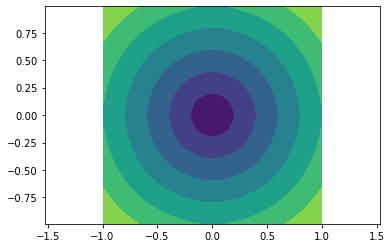

In [8]:
hfmIn['metric'] = metric
hfmOut_ad,values_ad = hfmIn.Run()
plt.axis('equal')
plt.contourf(*X,values_ad.gradient(0)); 

The caching of the geodesicflow could be done manually.

--- First run for caching geodesic flow information ---
Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.010647 s.
Filling cache data
--- Second run using cached data :  dict_keys(['values', 'activeNeighs', 'geodesicFlow'])  ---
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


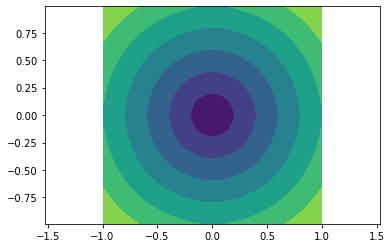

In [9]:
print("--- First run for caching geodesic flow information ---")
hfmIn_noad = hfmIn.copy()
hfmIn_noad['metric'] = ad.remove_ad(metric,iterables=(Metrics.Base,))
cache = Eikonal.Cache(needsflow=True)
hfmIn_noad.Run(cache=cache)

print("--- Second run using cached data : ", cache.contents.keys()," ---")
hfmOut_ad,values_ad = hfmIn.Run(cache=cache)
plt.axis('equal')
plt.contourf(*X,values_ad.gradient(0));

### 1.2 Rander example

Rander metrics are a generalization of Riemannian metrics, involving an additional asymmetric part. 
In particular, any Riemannian metric can be cast into a Rander metric, which allows to use automatic differentiation in this context. We reproduce an instance of Zermelo's navigation problem under a drift, which involves a Rander metric, see notebook [Rander](Rander.ipynb)

In [10]:
R = np.linalg.norm(X,axis=0)
driftMult = 0.9*np.sin(2*np.pi*X[0])*np.sin(2.*np.pi*X[1])
drift = (driftMult/R) * X
zermelo = Metrics.Rander.from_Zermelo(np.eye(2),drift)

Independent perturbations are applied to the symmetric and antisymmetric part of the metric.

In [11]:
delta = ad.Dense.identity(shape=(3,))
zermelo_ad = Metrics.Rander(zermelo.m *( 1 + delta[0]*(X[0]>2*X[1]) + delta[1]*(X[0]<=2*X[1]) ), 
                            zermelo.w*(1+delta[2]) )

In [12]:
hfmIn['metric']=zermelo_ad
hfmOut,values = hfmIn.Run()
values_zermelo_forward = values

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.014925 s.
--- HFM call triggered above to compute geodesic flow ---
Filling cache data
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


We rely on Euler's identity for validation, which implies here that a weighted sum of the chosen perturbations equals the distance map.

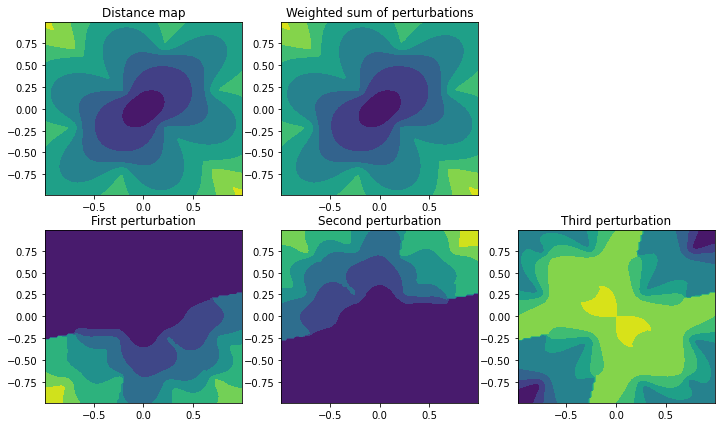

In [13]:
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plt.title('Distance map')
plt.contourf(*X,values.value)
plt.subplot(2,3,2)
plt.title('Weighted sum of perturbations')
plt.contourf(*X,2*values.gradient(0)+2*values.gradient(1)+values.gradient(2));
plt.subplot(2,3,4)
plt.title('First perturbation')
plt.contourf(*X,values.gradient(0))
plt.subplot(2,3,5)
plt.title('Second perturbation')
plt.contourf(*X,values.gradient(1))
plt.subplot(2,3,6)
plt.title('Third perturbation')
plt.contourf(*X,values.gradient(2));

### 1.3 Seismic example

In [14]:
seismicIn = Eikonal.dictIn({
    'model':'Seismic2',
    'arrayOrdering':'RowMajor',
    'extractValues':1,
    'seeds':[[0.,0.]],
    'exportGeodesicFlow':1.,
})

# Define the domain, get the coordinate grid
seismicIn.SetRect(sides=[[-2,2],[-1,1]],dimx=201)
X,Z = seismicIn.Grid()

# Make small oscillations in the tilting angle
delta = ad.Dense.identity(shape=(3,))

seismic_ad = Hooke.mica[0].extract_xz()
seismic_ad.hooke = fd.as_field(seismic_ad.hooke,X.shape) * (1+delta[0]*(X>=2*Z)+delta[1]*(X<2*Z))

tiltAngle = (np.pi/6.)*np.sin(np.pi*X+1.
    + delta[0]*(X>=0) +delta[1]*(X<0) - delta[2])
seismic_ad.rotate_by(tiltAngle)

seismicIn['metric']=seismic_ad

In [15]:
hfmOut,values = seismicIn.Run()
values_seismic_forward=values

Requesting cacheable data


Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.145067 s.
--- HFM call triggered above to compute geodesic flow ---
Filling cache data


Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


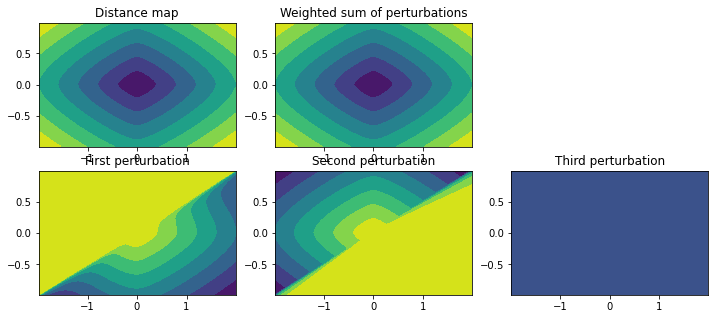

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(2,3,1)
plt.title('Distance map')
plt.contourf(X,Z,values.value)
plt.subplot(2,3,2)
plt.title('Weighted sum of perturbations')
values_wsum = -2*(values.gradient(0)+values.gradient(1)+values.gradient(2))
plt.contourf(X,Z,values_wsum);
plt.subplot(2,3,4)
plt.title('First perturbation')
plt.contourf(X,Z,values.gradient(0))
plt.subplot(2,3,5)
plt.title('Second perturbation')
plt.contourf(X,Z,values.gradient(1))
plt.subplot(2,3,6)
plt.title('Third perturbation')
plt.contourf(X,Z,values.gradient(2));

In [17]:
assert norm_infinity(values.value-values_wsum)<1e-8

## 2. Reverse differentiation 

We reproduce and validate the previous examples using reverse automatic differentiation, which allows the efficient computation of the gradient of an objective function defined in terms of the output values of fast marching method, w.r.t. each component of the input metric.

### 2.1 Isotropic example

In [18]:
cost = np.ones(hfmIn['dims'].astype(int))
rev,cost_ad = ad.Reverse.empty(inputs=cost,input_iterables = (Eikonal.dictIn,Metrics.Base))
metric_ad =  Metrics.Isotropic(cost_ad)
hfmIn['metric'] = metric_ad

In [19]:
hfmOut,values_ad = rev.apply(Eikonal.dictIn.Run,hfmIn,cache=Eikonal.Cache())

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008332 s.
Filling cache data


In [20]:
X=hfmIn.Grid()
interp = UniformGridInterpolation(X,values_ad)
x0 = (0.2,0.8); x1 = (-0.5,-0.9); alpha0 = 1.2; alpha1 = 0.7
objective = alpha0*interp(x0)+alpha1*interp(x1)

In [21]:
objective

spAD(array(1.72040888), array([0.048  , 0.072  , 0.432  , 0.648  , 0.28875, 0.23625, 0.09625,
       0.07875]), array([-6253, -6252, -6152, -6151, -2531, -2530, -2430, -2429]))

In [22]:
grad, = rev.to_inputshapes(rev.gradient(objective))

Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


The support of the gradient approximates the geodesics, which in the case of a constant metric are straight lines.

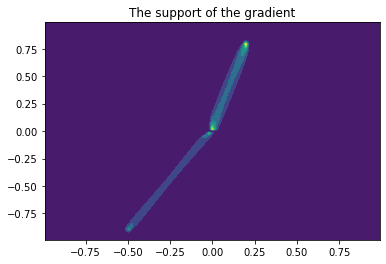

In [23]:
plt.title("The support of the gradient")
plt.contourf(*X,grad);

### 2.2 Rander example

We reproduce Zermelo's navigation problem presented in the first section, and cross validate the forward and reverse automatic differentiation methods.

In [24]:
rev,zermelo_rev = ad.Reverse.empty(inputs=zermelo,input_iterables = (Eikonal.dictIn,Metrics.Base))
hfmIn['metric'] = zermelo_rev

In [25]:
hfmOut,values_ad = rev.apply(Eikonal.dictIn.Run,hfmIn,cache=Eikonal.Cache())

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.015021 s.
Filling cache data


In [26]:
X=hfmIn.Grid()
interp = UniformGridInterpolation(X,values_ad)
objective = alpha0*interp(x0)+alpha1*interp(x1)

In [27]:
grad_m,grad_w = rev.to_inputshapes(rev.gradient(objective))

Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


We validate the results by comparing forward and reverse automatic differentiation, of the above objective function, with the above variations in the Rander metric.

In [28]:
sensitivity_reverse = np.array(
    [ (grad_m*zermelo_ad.m.gradient(i)).sum() + (grad_w*zermelo_ad.w.gradient(i)).sum() for i in range(3)])
print(f"Gradient of the objective function w.r.t. three variations in the metric : {sensitivity_reverse}")

Gradient of the objective function w.r.t. three variations in the metric : [ 0.61552158  0.6992123  -0.82402924]


In [29]:
interp = UniformGridInterpolation(X,values_zermelo_forward)
sensitivity_forward = (alpha0*interp(x0)+alpha1*interp(x1)).coef

In [30]:
assert ad.Optimization.norm_infinity(sensitivity_reverse-sensitivity_forward) < 1e-15

### 2.3 Seismic example

In [31]:
seismic_rev = copy(seismic_ad)
rev,seismic_rev.hooke = ad.Reverse.empty(inputs=seismic_ad.hooke.value, input_iterables = (Eikonal.dictIn,Metrics.Base))
seismicIn['metric'] = seismic_rev

In [32]:
hfmOut,values_rev = rev.apply(Eikonal.dictIn.Run,seismicIn,cache=Eikonal.Cache())

Requesting cacheable data


Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.115001 s.
Filling cache data


In [33]:
X,Z = seismicIn.Grid()
interp = UniformGridInterpolation(np.array((X,Z)),values_rev)
objective = alpha0*interp(x0)+alpha1*interp(x1)

In [34]:
grad_hooke, = rev.to_inputshapes(rev.gradient(objective))

Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


Again, we validate the results by comparing forward and reverse automatic differentiation, of the above objective function, with the above variations in the Rander metric.

In [35]:
sensitivity_reverse = np.array([ (grad_hooke*seismic_ad.hooke.gradient(i)).sum() for i in range(3)])
print(f"Gradient of the objective function w.r.t. three variations in the metric {sensitivity_reverse}")

Gradient of the objective function w.r.t. three variations in the metric [-0.04829966 -0.06817261  0.        ]


In [36]:
interp = UniformGridInterpolation(np.array([X,Z]),values_seismic_forward)
sensitivity_forward = (alpha0*interp(x0)+alpha1*interp(x1)).coef

In [37]:
assert norm_infinity(sensitivity_reverse-sensitivity_forward) < 1e-16

## 3. Geodesic flow and gradient of the value function

Semi-Lagrangian schemes provide an intrinsic, upwind estimate of the geodesic flow and gradient of the value function. We illustrate here their computation, and discuss their differentiation, with respect to perturbations of the metric, which is subject to substantial limitations due to the nature of the numerical scheme.

Note that there are alternative approaches to computing the gradient of the value function, which are simpler and may be adequate in applications, such as centered finite differences along the coordinate axes. The interest of the upwind gradient should be more stable is that it should be the most stable.

### 3.1 Computing the gradient

The HFM library provides a numerical approximation of geodesic flow, which can be used to reconstruct a gradient. For that purpose, one relies on norm duality, thanks to the formula:
$$
    \nabla u(x) = \nabla F_x( V(x) )
$$
Surprisingly, when the approximate geodesic flow is used in place of $V(x)$, then the resulting approximation of $\nabla u(x)$ can be interpreted in terms of finite differences, in the causal stencil used by the fast marching method.

In [38]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'metric':zermelo,
    'seeds':[[0,0]],
    'exportGeodesicFlow':True,
    'extractValues':True,
})
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=101)
X = hfmIn.Grid()
h = hfmIn['gridScale']

In [39]:
hfmOut,values = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.014507 s.


Compute the gradient using finite differences and norm duality.

In [40]:
grad_fd = fd.DiffGradient(values,gridScale=h)

In [41]:
grad_hfm = hfmIn['metric'].gradient(hfmOut['flow'])

/Users/mirebeau/Dropbox/Programmes/Github/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:24: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1))
/Users/mirebeau/Dropbox/Programmes/Github/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense.py:95: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef)


The two results are quite similar.

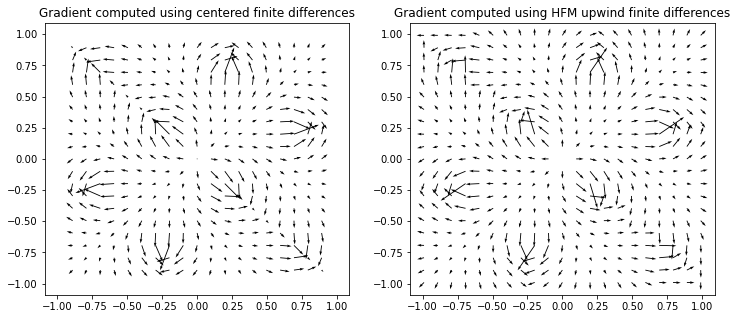

In [42]:
s = 5
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Gradient computed using centered finite differences")
plt.quiver(*X[:,::s,::s],*grad_fd[:,::s,::s])
plt.subplot(1,2,2)
plt.title("Gradient computed using HFM upwind finite differences")
plt.quiver(*X[:,::s,::s],*grad_hfm[:,::s,::s]);

Note that the centered finite differences gradient is not computed along the boundary, whereas the upwind gradient is not computed at the seed point(s).

In [43]:
nan_fd = np.any(np.isnan(grad_fd),axis=0)
nan_hfm = np.any(np.isnan(grad_hfm),axis=0)

print(f"Ill defined centered gradients {nan_fd.sum()}. \n"
      f"Ill defined upwind gradients {nan_hfm.sum()}.")

Ill defined centered gradients 400. 
Ill defined upwind gradients 1.


The main differences between the centered and upwind gradients arise near the cut locus, and where the metric is strongly anisotropic.

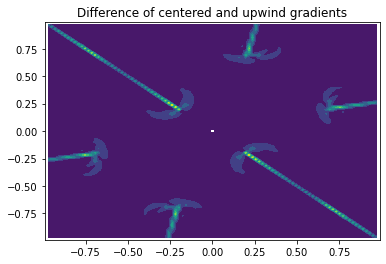

In [44]:
grad_diff = ad.Optimization.norm(grad_fd-grad_hfm,axis=0)
plt.title("Difference of centered and upwind gradients")
plt.contourf(*X,grad_diff);

<!---
s = 5
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Gradient computed using centered finite differences")
plt.contourf(*X,nan_fd)
plt.subplot(1,2,2)
plt.title("Gradient computed using HFM upwind finite differences")
plt.contourf(*X,nan_hfm);
--->

### 3.2 Differentiating the gradient

Some applications, such as travel-time tomography, require to differentiate the gradient of the value function w.r.t. variations in the cost function. 
The centered finite differences approach extends in a straightforward manner to this setting. 

For a technical reason, the situation is more complex with upwind finite differences, because they involve offsets defining an angular sector which often degenerates. More precisely, the semi-Lagrangian scheme solves a minimization problem over a polygonal neighborhood of each point, whose extremum may be attained in a lower dimensional facet. See introduction.

In that case, the upwind gradient is well defined, but it cannot be differentiated in an upwind manner.

<!---
Semi-Lagrangian schemes can be used to compute the gradient 


The value function produced by semi-Lagrangian schemes is not differentiable at every point.
Indeed, the optimal direction found may be within a lower dimensional simplex, in which case it a locking effect arises.

There are several approaches to compute the gradient of the value function:
- using finite differences on the value function, e.g. centered and along the principal axes.
- using norm duality, and the fact that it is dual to the geodesic flow.
$$
    \nabla u(x) = \nabla F_x( V(x) )
$$


Both approaches are compatible with automatic differentiation, forward and reverse. Regarding the dual approach, the following comments are in order:
- it is equivalent to computing an upwind gradient using the same stencil as the fast marching method.
- compatibility with AD follows, once again, from the envelope theorem. Considering a perturbation parametrized by a small $\epsilon$ one has 
$$
    \nabla u(x; \epsilon) = \nabla F_x( V(x; 0); \epsilon) + o(\epsilon)
$$
Note, crucially, that we can set $\epsilon=0$ in $V$, by the envelope theorem.--->

<!---
Conversely, the derivative of the geodesic flow can be recovered from the gradient:
$$
V(x;\epsilon) = \nabla F_x^*(\nabla u(x; \epsilon); \epsilon)
$$
--->

In [45]:
hfmIn.update({'exportActiveOffsets':True,'metric':zermelo_ad})

In [46]:
hfmOut,values_ad = hfmIn.Run()

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.014123 s.
--- HFM call triggered above to compute geodesic flow ---
Filling cache data
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Bypassing fast marching solver based on cached data.


In [47]:
grad_fd_ad = fd.DiffGradient(values_ad,gridScale=h)

We exported the active stencils used in the fast-marching algorithm.

In [48]:
offsets = hfmOut['offsets']
du_ad = fd.DiffUpwind(values_ad,offsets,h)

valid = lp.det(offsets)!=0
inv_offsets = np.full(offsets.shape,np.nan)
inv_offsets[:,:,valid] = lp.inverse(offsets[:,:,valid].astype(float))

grad_hfm_ad = lp.dot_VA(du_ad,inv_offsets)

This lets us reconstruct an upwind gradient. As discussed above, this does not apply in places where the semi-Lagrangian scheme selects an extremal point of the stencil.

Proportion of valid points 0.9322615429859817


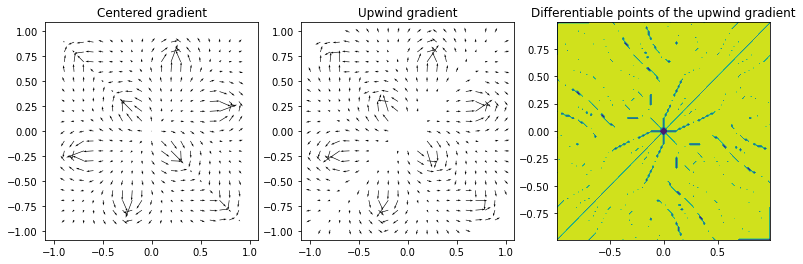

In [49]:
print(f"Proportion of valid points {valid.sum()/valid.size}")
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.title("Centered gradient")
s=5; plt.quiver(*X[:,::s,::s],*grad_fd_ad.value[:,::s,::s]);
plt.subplot(1,3,2)
plt.title("Upwind gradient")
s=5; plt.quiver(*X[:,::s,::s],*grad_hfm_ad.value[:,::s,::s]);
plt.subplot(1,3,3)
plt.title("Differentiable points of the upwind gradient")
plt.contourf(*X,valid);

As announced, the upwind finite differences and the method based on norm duality produce the same values, up to machine precision, where they are defined.

In [50]:
grad_diff = grad_hfm_ad.value - grad_hfm
grad_diff_norm = np.where(valid,ad.Optimization.norm(grad_diff,axis=0),0.)
assert norm_infinity(grad_diff_norm)<1e-11

The value function is non-differentiable along the second diagonal, which is part of the cut locus (a.k.a. the points where the value function is not differentiable). For that reason, the centered gradient derivatives yield huge and meaningless values in this along this diagonal. In contrast, the upwind gradient is better behaver in the neighborhood of the cut locus.

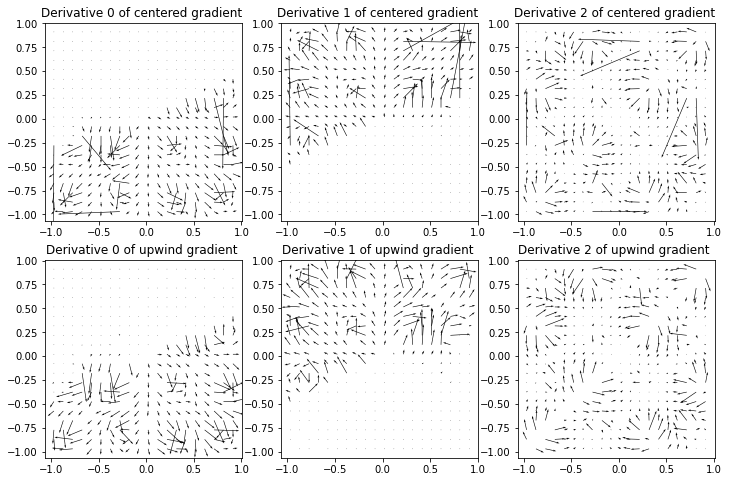

In [51]:
plt.figure(figsize=(12,8))
for i,grad in enumerate((grad_fd_ad,grad_hfm_ad)):
    s=5; sl = slice(None,None,s) if i==1 else slice(1,-1,s)
    for j in range(3):
        plt.subplot(2,3,1+3*i+j)
        plt.title(f"Derivative {j} of {'upwind' if i==1 else 'centered'} gradient ")
        plt.quiver(*X[:,1:-1:s,1:-1:s],*grad.gradient(j)[:,1:-1:s,1:-1:s]);

### 3.3 Differentiating the geodesic flow

The geodesic flow can be recovered from the gradient using norm duality.
$$
    V(x) = \nabla F^*_x(\nabla u(x)),
$$
where $F^*$ denotes the dual metric. This approach is compatible with automatic differentiation.

In [52]:
flow_hfm_ad = zermelo_ad.dual().gradient(grad_hfm_ad)

The constant part matches the output of the HFM library.

In [53]:
flow_diff = flow_hfm_ad.value - hfmOut['flow']
flow_diff_norm = np.where(valid,ad.Optimization.norm(flow_diff,axis=0),0.)
assert norm_infinity(flow_diff_norm)<1e-11

For validating the first order part, we dualize once more, to recover the upwind gradient.

In [54]:
grad_hfm_ad2 = zermelo_ad.gradient(flow_hfm_ad)
grad_diff_ad = grad_hfm_ad2 - grad_hfm_ad
grad_diff_ad_norm = np.where(valid,ad.Optimization.norm(grad_diff_ad.gradient(),axis=(0,1)),0.)
assert norm_infinity(grad_diff_ad_norm) < 1e-11